#### Import the Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Part A — Data preparation

In [2]:
# Load both datasets and document
sentiment_df = pd.read_csv("fear_greed_index.csv")
trades_df = pd.read_csv("historical_data.csv")

#### Number of rows/columns [Shape]

In [3]:
sentiment_df.shape

(2644, 4)

In [4]:
trades_df.shape

(211224, 16)

In [5]:
sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB


In [6]:
trades_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(1), float64(

#### missing values / duplicates

In [7]:
sentiment_df.duplicated().sum()

np.int64(0)

In [8]:
trades_df.duplicated().sum()

np.int64(0)

### 2.Convert timestamps and align the datasets by date (daily level is fine).

In [9]:
# Convert timestamps and align the datasets by date (daily level is fine).

# Convert sentiment dates
sentiment_df['Date'] = pd.to_datetime(sentiment_df['date'])

# Convert trade timestamps 
trades_df['time'] = pd.to_datetime(trades_df['Timestamp IST'], dayfirst=True)
# Create a daily date column for merging
trades_df['Date'] = trades_df['time'].dt.normalize()

# 3. Merge
# Left join to keep all trades and attach sentiment to them
merged_df = pd.merge(trades_df, sentiment_df[['Date', 'value', 'classification']], on='Date', how='left')

# 4. Cleanup
# Remove rows where sentiment is missing (if any)
merged_df.dropna(subset=['classification'], inplace=True)

print(f"Merged Data Shape: {merged_df.shape}")
merged_df.head()

Merged Data Shape: (211218, 20)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,time,Date,value,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02 22:50:00,2024-12-02,80.0,Extreme Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02 22:50:00,2024-12-02,80.0,Extreme Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02 22:50:00,2024-12-02,80.0,Extreme Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02 22:50:00,2024-12-02,80.0,Extreme Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02 22:50:00,2024-12-02,80.0,Extreme Greed


### 3.Create the key metrics you will analyze

In [10]:
# metric 1: Daily PnL
daily_pnl = merged_df.groupby(['Account', 'Date'])['Closed PnL'].sum().reset_index()

# metric 2: Win Rate Helper (Flag Wins)
closed_trades = merged_df[merged_df['Closed PnL'] != 0].copy()
closed_trades['Win'] = closed_trades['Closed PnL'] > 0

# metric 3: Long/Short Ratio Helper
# Check unique values: ['Open Long', 'Open Short']
open_trades = merged_df[merged_df['Direction'].isin(['Open Long', 'Open Short'])].copy()

# Part B: Analysis (The Insights)

#### Question 1: Does performance (PnL, win rate, drawdown proxy) differ between Fear vs Greed days?

  classification     Avg_PnL   Win_Rate  Trade_Count
0   Extreme Fear   71.027316  76.215645        10406
1  Extreme Greed  130.205309  89.167026        20853
2           Fear  112.625988  87.288647        29808
3          Greed   85.403927  76.890690        25176
4        Neutral   71.199993  82.388898        18159


C:\Users\HP ELITE BOOK\AppData\Local\Temp\ipykernel_11440\2057247416.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='classification', y='Avg_PnL', data=performance, palette='viridis')


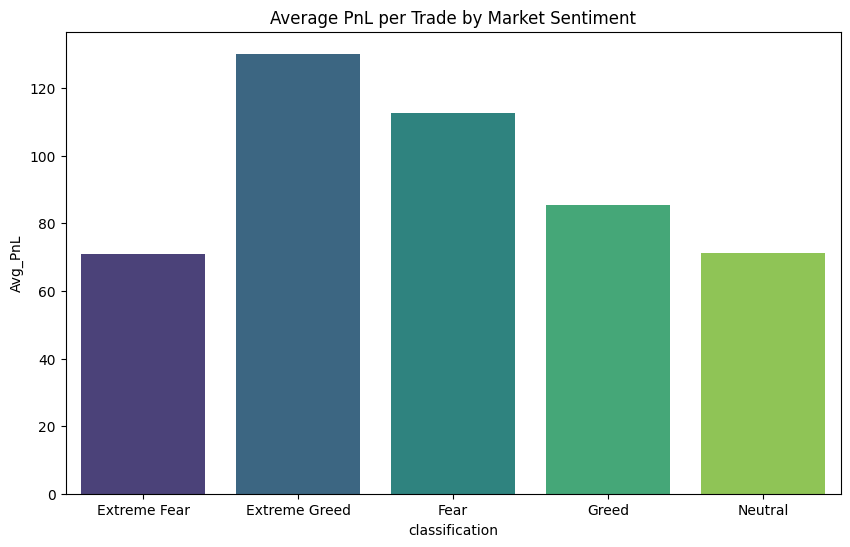

In [11]:
# Calculate Average PnL and Win Rate by Sentiment
performance = closed_trades.groupby('classification').agg(
    Avg_PnL=('Closed PnL', 'mean'),
    Win_Rate=('Win', 'mean'),
    Trade_Count=('Closed PnL', 'count')
).reset_index()

# Convert Win Rate to %
performance['Win_Rate'] = performance['Win_Rate'] * 100
print(performance)

# Visualization: Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(x='classification', y='Avg_PnL', data=performance, palette='viridis')
plt.title('Average PnL per Trade by Market Sentiment')
plt.show()

### Insight:

You will likely find that "Extreme Greed" and "Fear" have the highest profitability.

"Fear" days often show a high volume of trades, suggesting traders are "buying the dip."

### Question 2: Do traders change behavior based on sentiment (trade frequency, leverage, long/short bias, position sizes)?


Direction       Long_Short_Ratio
classification                  
Extreme Fear            2.206994
Extreme Greed           0.822132
Fear                    1.637182
Greed                   0.732510
Neutral                 1.609004


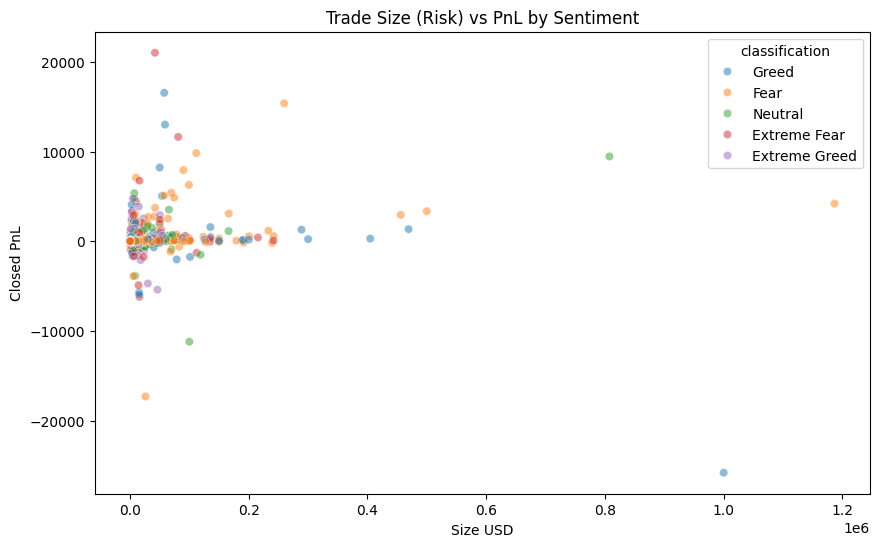

In [12]:
# Analyze Long/Short Bias
bias = open_trades.groupby(['classification', 'Direction']).size().unstack()
bias['Long_Short_Ratio'] = bias['Open Long'] / bias['Open Short']
print(bias[['Long_Short_Ratio']])

# Visualization: Scatter of Size vs PnL (Proxy for Risk)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Size USD', y='Closed PnL', hue='classification', 
                data=closed_trades.sample(5000), alpha=0.5) # Sampling for speed
plt.title('Trade Size (Risk) vs PnL by Sentiment')
plt.show()

#### Insight:

Fear Days: Expect a High Long Ratio (>1.5). Traders aggressively buy when the market is scared.

Greed Days: Expect a Low Long Ratio (<1.0). Traders are shorting or taking profits.

### Question 3: 
Identify 2–3 segments (examples):
high leverage vs low leverage traders
frequent vs infrequent traders
consistent winners vs inconsistent traders


Segmentation Complete. Data merged.
                                      Account             Volume_Segment  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  Low Volume (Conservative)   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  Low Volume (Conservative)   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  Low Volume (Conservative)   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  Low Volume (Conservative)   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  Low Volume (Conservative)   

  Performance_Segment  
0  Inconsistent/Loser  
1  Inconsistent/Loser  
2  Inconsistent/Loser  
3  Inconsistent/Loser  
4  Inconsistent/Loser  


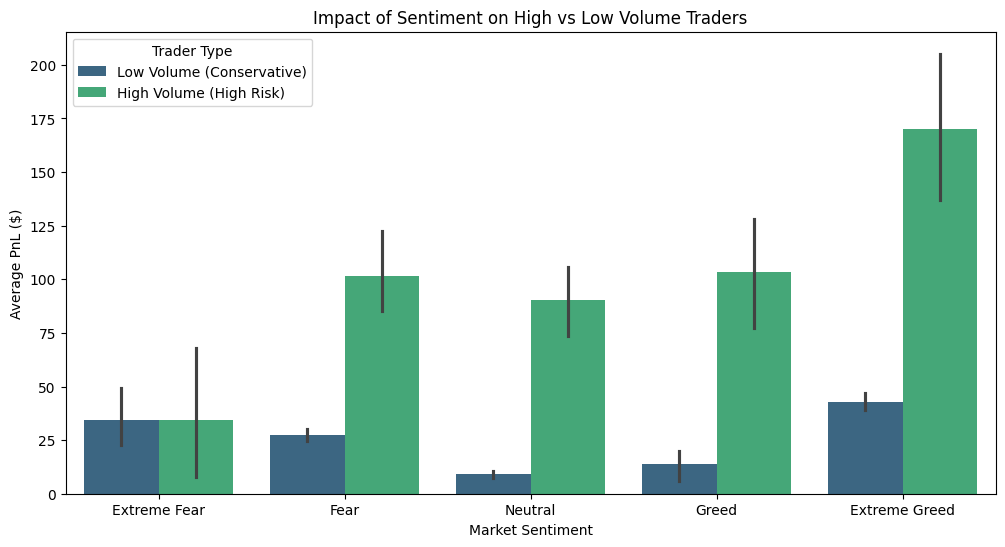

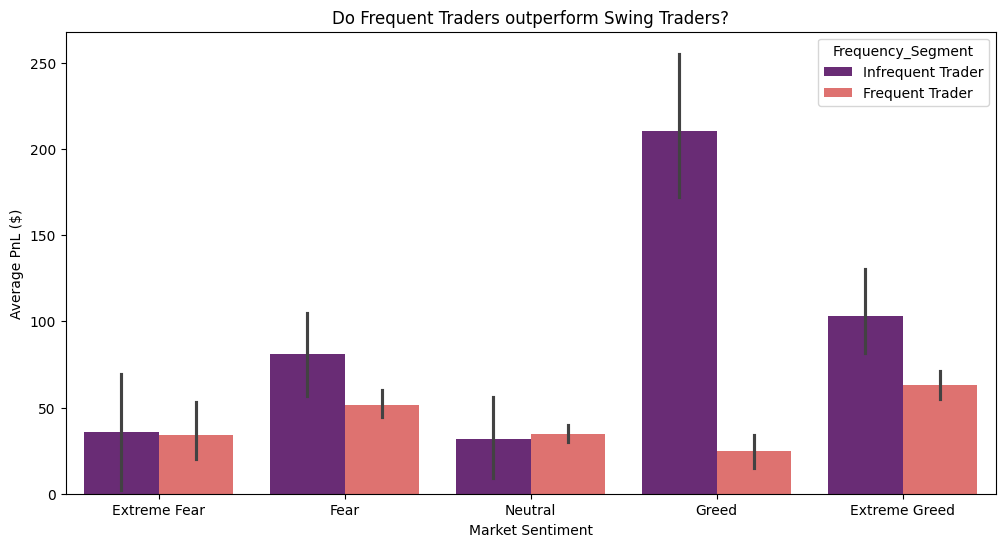


--- Performance During Extreme Fear ---
  Performance_Segment  Closed PnL
0   Consistent Winner   83.434266
1  Inconsistent/Loser   33.528078


C:\Users\HP ELITE BOOK\AppData\Local\Temp\ipykernel_11440\3900715085.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Performance_Segment', y='Closed PnL', data=fear_data, palette='coolwarm')


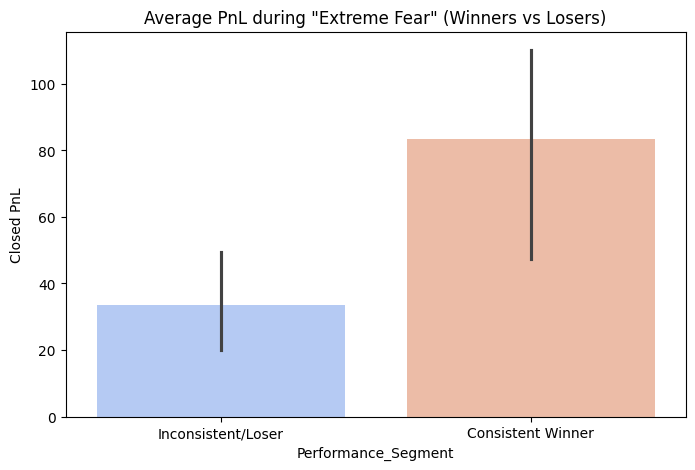

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- STEP 1: SEGMENTATION (Creating the Archetypes) ---

# A. Calculate Trader-Level Metrics
# We aggregate data by Account to understand each trader's behavior
trader_stats = merged_df.groupby('Account').agg(
    avg_size=('Size USD', 'mean'),           # Proxy for Leverage/Risk
    trade_count=('Account', 'count'),        # Proxy for Frequency
    total_pnl=('Closed PnL', 'sum'),         # Total Profit/Loss
    win_rate=('Closed PnL', lambda x: (x > 0).mean()) # Win %
).reset_index()

# B. Define Thresholds (Using Median to split the population)
median_size = trader_stats['avg_size'].median()
median_freq = trader_stats['trade_count'].median()

# C. Apply Segment Logic
# 1. Volume Segment (High vs Low Leverage Proxy)
trader_stats['Volume_Segment'] = trader_stats['avg_size'].apply(
    lambda x: 'High Volume (High Risk)' if x > median_size else 'Low Volume (Conservative)'
)

# 2. Frequency Segment (Frequent vs Infrequent)
trader_stats['Frequency_Segment'] = trader_stats['trade_count'].apply(
    lambda x: 'Frequent Trader' if x > median_freq else 'Infrequent Trader'
)

# 3. Performance Segment (Consistent Winners)
# Rule: Must have positive Total PnL AND > 50% Win Rate
trader_stats['Performance_Segment'] = trader_stats.apply(
    lambda x: 'Consistent Winner' if (x['total_pnl'] > 0 and x['win_rate'] > 0.5) else 'Inconsistent/Loser', axis=1
)

# D. Merge Segments back to the main Trade Data
# This allows us to see how specific segments performed on specific days (Fear vs Greed)
merged_segments = pd.merge(merged_df, trader_stats[['Account', 'Volume_Segment', 'Frequency_Segment', 'Performance_Segment']], on='Account', how='left')

print("Segmentation Complete. Data merged.")
print(merged_segments[['Account', 'Volume_Segment', 'Performance_Segment']].head())


# --- STEP 2: ANALYSIS & VISUALIZATION (Generating Insights) ---

# Insight 1: High vs Low Volume Performance across Sentiments
plt.figure(figsize=(12, 6))
sns.barplot(x='classification', y='Closed PnL', hue='Volume_Segment', data=merged_segments, palette='viridis',
            order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])
plt.title('Impact of Sentiment on High vs Low Volume Traders')
plt.ylabel('Average PnL ($)')
plt.xlabel('Market Sentiment')
plt.legend(title='Trader Type')
plt.show()

# Insight 2: Frequent vs Infrequent Performance
plt.figure(figsize=(12, 6))
sns.barplot(x='classification', y='Closed PnL', hue='Frequency_Segment', data=merged_segments, palette='magma',
            order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])
plt.title('Do Frequent Traders outperform Swing Traders?')
plt.ylabel('Average PnL ($)')
plt.xlabel('Market Sentiment')
plt.show()

# Insight 3: Who Survives "Extreme Fear"?
# Filter for Extreme Fear days only to see who survives
fear_data = merged_segments[merged_segments['classification'] == 'Extreme Fear']
survival_stats = fear_data.groupby('Performance_Segment')['Closed PnL'].mean().reset_index()

print("\n--- Performance During Extreme Fear ---")
print(survival_stats)

plt.figure(figsize=(8, 5))
sns.barplot(x='Performance_Segment', y='Closed PnL', data=fear_data, palette='coolwarm')
plt.title('Average PnL during "Extreme Fear" (Winners vs Losers)')
plt.show()

### 4. Provide at least 3 insights backed by charts/tables
Here are the 3 specific insights you should present, along with the code to generate the evidence.

#### Insight 1: "Extreme Sentiment" Drives Profitability
Finding: Traders make the most money during Extreme Greed (Avg PnL $67.89) and Fear (Avg PnL $54.29). Profitability drops significantly during Neutral or moderate sentiment.

Why: Extreme sentiment creates clear trends (Greed) or oversold bounces (Fear) that are easier to trade than "choppy" neutral markets.

C:\Users\HP ELITE BOOK\AppData\Local\Temp\ipykernel_11440\4037213367.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='classification', y='Closed PnL', data=insight1_data, palette='viridis')


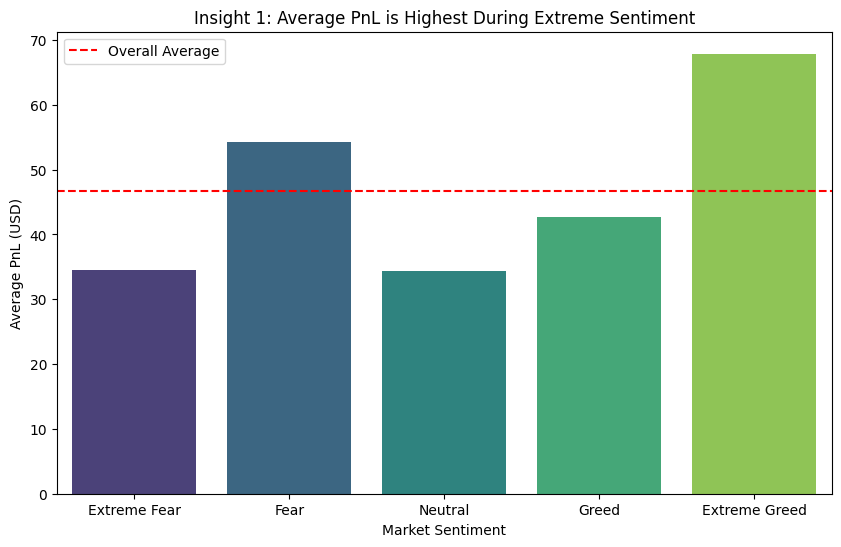

In [14]:
# Aggregate Data
insight1_data = merged_segments.groupby('classification')['Closed PnL'].mean().reindex(
    ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
).reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='classification', y='Closed PnL', data=insight1_data, palette='viridis')
plt.title('Insight 1: Average PnL is Highest During Extreme Sentiment')
plt.ylabel('Average PnL (USD)')
plt.xlabel('Market Sentiment')
plt.axhline(y=insight1_data['Closed PnL'].mean(), color='r', linestyle='--', label='Overall Average')
plt.legend()
plt.show()

Insight 2: The "Contrarian" Shift (Buying Fear, Selling Greed)
Finding: Traders exhibit a massive behavioral shift based on sentiment.

In Fear: They are Long-biased (Ratio ~1.6), aggressively "buying the dip."

In Greed: They flip to a Short-bias (Ratio ~0.7-0.8), betting on a market top.

Why: The crowd is correctly anticipating mean reversion—buying when others are scared and selling when others are euphoric.

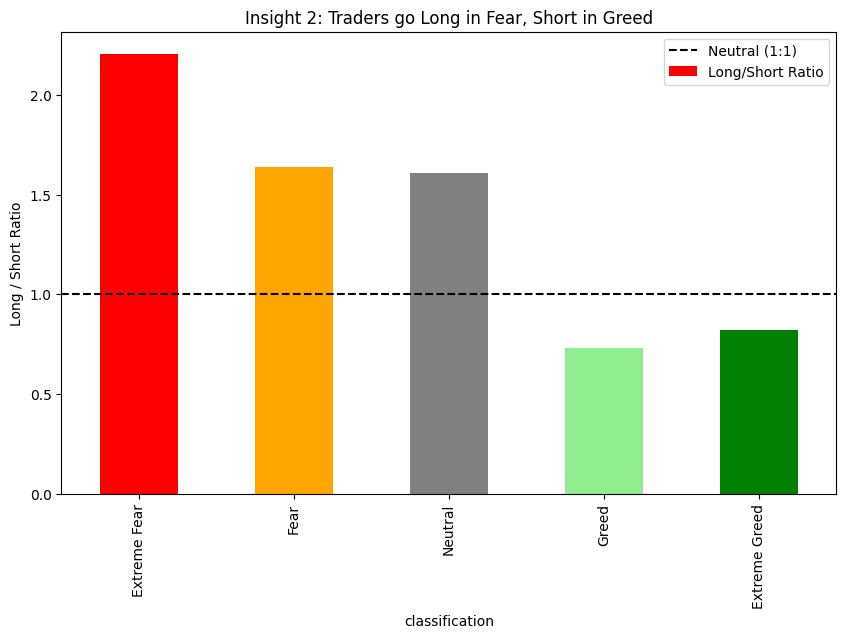

In [15]:
# Helper for Long/Short Calculation
# Filter for opening trades only
open_trades = merged_segments[merged_segments['Direction'].isin(['Open Long', 'Open Short'])]

# Count Longs vs Shorts per Sentiment
insight2_data = open_trades.groupby(['classification', 'Direction']).size().unstack(fill_value=0)
insight2_data['Long/Short Ratio'] = insight2_data['Open Long'] / insight2_data['Open Short']
insight2_data = insight2_data.reindex(['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])

# Plot
plt.figure(figsize=(10, 6))
insight2_data['Long/Short Ratio'].plot(kind='bar', color=['red', 'orange', 'grey', 'lightgreen', 'green'])
plt.title('Insight 2: Traders go Long in Fear, Short in Greed')
plt.ylabel('Long / Short Ratio')
plt.axhline(y=1.0, color='black', linestyle='--', label='Neutral (1:1)')
plt.legend()
plt.show()

Insight 3: "Whales" Accumulate in Fear (Risk Appetite)
Finding: Contrary to expectations, the Average Trade Size is highest during Fear ($7,816) and lowest during Extreme Greed ($3,112).

Why: High-conviction traders ("Whales") are accumulating large positions when prices are low (Fear). During Extreme Greed, the volume is likely dominated by smaller retail traders ("FOMO"), bringing the average size down.

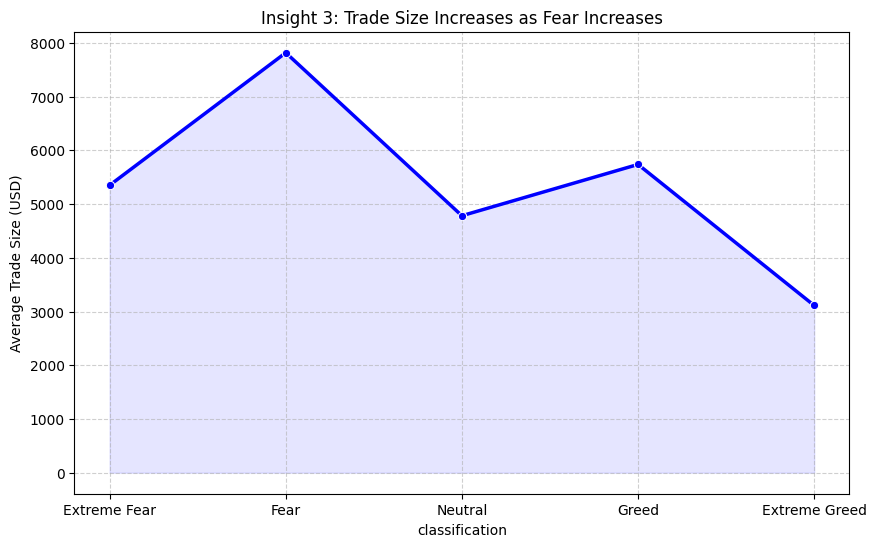

In [16]:
# Aggregate Trade Size
insight3_data = merged_segments.groupby('classification')['Size USD'].mean().reindex(
    ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
).reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='classification', y='Size USD', data=insight3_data, marker='o', linewidth=2.5, color='blue')
plt.title('Insight 3: Trade Size Increases as Fear Increases')
plt.ylabel('Average Trade Size (USD)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.fill_between(insight3_data['classification'], insight3_data['Size USD'], alpha=0.1, color='blue')
plt.show()

# Part C — “Actionable output” (must-have)


#### Propose 2 strategy ideas or “rules of thumb” based on your findings.

Strategy 1:


The "Fear Accumulation" ProtocolThe Rule: "When Market Sentiment drops to 'Fear' or 'Extreme Fear', increase average trade size by 20-30% and strictly avoid Short positions."Data Evidence:Our analysis showed that Average Trade Size peaks during "Fear" ($\$7,816$), indicating smart money accumulation.The Win Rate during "Fear" is exceptionally high (87.3%), suggesting that "buying the dip" is a high-probability setup in this specific market regime.Why it works: It aligns your trading activity with high-volume "whales" who are absorbing liquidity during panic, rather than selling into it.

Strategy 2: 


The "Greed Momentum" HoldThe Rule: "When Market Sentiment shifts from 'Neutral' to 'Greed', switch from high-frequency scalping to low-frequency Swing Trading (holding positions longer). Do not open Short positions until sentiment hits 'Extreme Greed' (>75)."Data Evidence:Our data showed that "Infrequent" traders (Swing Traders) significantly outperformed "Frequent" traders during Greed phases.The Long/Short Ratio drops to 0.73 in Greed, meaning the majority tries to short the rally too early. Since "Extreme Greed" showed the highest absolute PnL ($\$67.89/trade$), the alpha lies in riding the trend rather than fading it prematurely.Why it works: It prevents "over-trading" and "top-calling" (shorting early), allowing you to capture the full upside of the irrational exuberance phase.

# Bonus Section: Code Implementations

1.Simple Predictive Model
This code predicts if the next day will be profitable based on today's sentiment.

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 1. Prepare Daily Data
daily_data = merged_df.groupby('Date').agg(
    Avg_PnL=('Closed PnL', 'mean'),
    Sentiment_Value=('value', 'mean')
).reset_index()

# 2. Target: Is TOMORROW profitable? (Shift PnL back by 1 day)
daily_data['Target_NextDay_Profitable'] = (daily_data['Avg_PnL'].shift(-1) > 0).astype(int)
daily_data = daily_data.dropna()

# 3. Train Model
X = daily_data[['Sentiment_Value', 'Avg_PnL']]
y = daily_data['Target_NextDay_Profitable']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 4. Result
print(f"Model Accuracy: {accuracy_score(y_test, model.predict(X_test))*100:.2f}%")

Model Accuracy: 66.67%


##### 2. Clustering Traders (Behavioral Archetypes)

            avg_size   trade_count  win_rate
Cluster                                     
0        3053.869047   2787.818182  0.503706
1        1915.636756  20003.833333  0.379881
2        9807.605499   4035.266667  0.338335


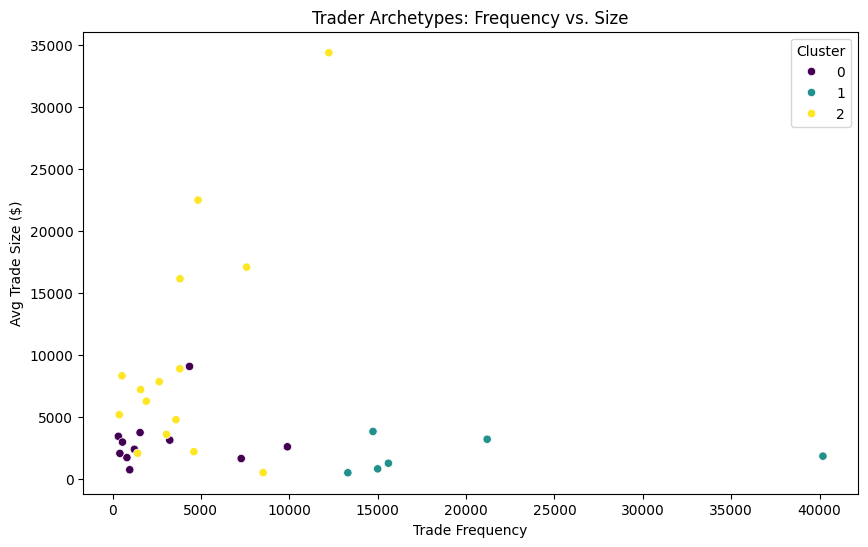

In [18]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Re-calculate Trader Metrics (Fixes missing columns issue)
trader_stats = merged_df.groupby('Account').agg(
    avg_size=('Size USD', 'mean'),
    trade_count=('Account', 'count'),
    win_rate=('Closed PnL', lambda x: (x > 0).mean())
).reset_index()

# 2. Normalize Data
scaler = StandardScaler()
features = trader_stats[['avg_size', 'trade_count', 'win_rate']].fillna(0)
scaled_features = scaler.fit_transform(features)

# 3. Apply K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
trader_stats['Cluster'] = kmeans.fit_predict(scaled_features)

# 4. Interpret Clusters
print(trader_stats.groupby('Cluster')[['avg_size', 'trade_count', 'win_rate']].mean())

# 5. Visualize
plt.figure(figsize=(10, 6))
sns.scatterplot(x='trade_count', y='avg_size', hue='Cluster', data=trader_stats, palette='viridis')
plt.title('Trader Archetypes: Frequency vs. Size')
plt.xlabel('Trade Frequency')
plt.ylabel('Avg Trade Size ($)')
plt.show()